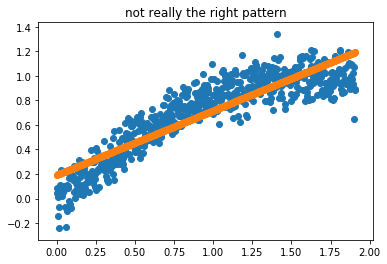

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression

n = 600
s = 0 

xs = np.arange(s, s + n)/100/np.pi
ys = np.sin(xs) + np.random.normal(0, 0.1, n)

pred_ys = LinearRegression().fit(xs.reshape(-1, 1), ys).predict(xs.reshape(-1, 1))
plt.scatter(xs, ys)
plt.scatter(xs, pred_ys)
plt.title("not really the right pattern");

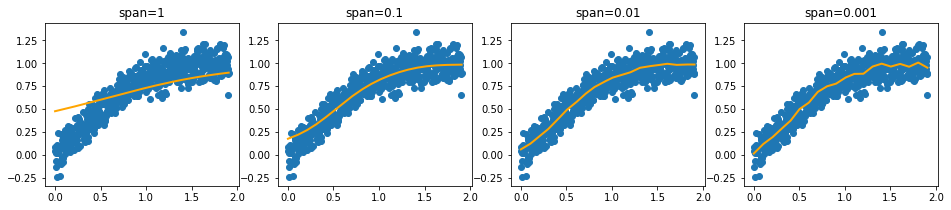

In [136]:
from sklego.preprocessing import IntervalEncoder

plt.figure(figsize = (16, 3))

for idx, sigma in enumerate([1, 0.1, 0.01, 0.001]):
    plt.subplot(140 + idx + 1)
    fs = IntervalEncoder(n_chunks=20, span=sigma, method='normal').fit(xs.reshape(-1, 1), ys)
    plt.scatter(xs, ys);
    plt.plot(xs, fs.transform(xs.reshape(-1, 1)), color='orange', linewidth=2.0)
    plt.title(f"span={sigma}");

In [158]:
def create_gte_constraints(betas):
    for i in range(betas.shape[0] - 1):
        yield betas[i + 1] >= betas[i]
        yield betas[i + 1] >= 0
    
def create_lte_constraints(betas):
    for i in range(betas.shape[0] - 1):
        yield betas[i + 1] <= betas[i]
        yield betas[i + 1] <= 0

In [159]:
import operator as op

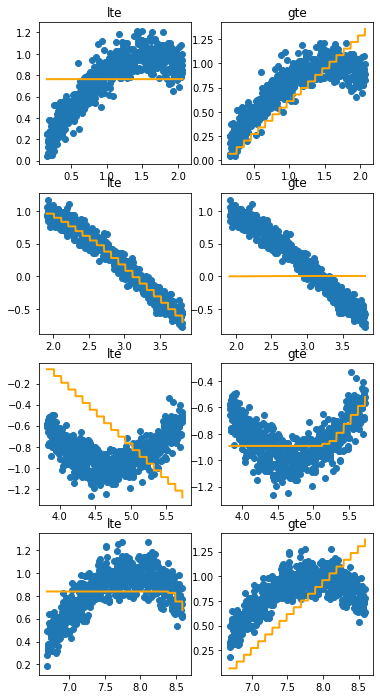

In [161]:
import cvxpy as cp
import numpy as np

i = 0
plt.figure(figsize=(6, 12))
for data_init in [50, 600, 1200, 2100]:
    n = 600
    s = data_init 

    xs = np.arange(s, s + n)/100/np.pi
    ys = np.sin(xs) + np.random.normal(0, 0.1, n)
    
    X = xs.reshape(-1, 1)
    n_chunks = 20

    quantiles_ = np.zeros((X.shape[1], n_chunks))

    for col in range(X.shape[1]):
        quantiles_[col, :] = np.quantile(X[:, col], q=np.linspace(0, 1, n_chunks))

    x_internal = np.array([xs >= i for i in quantiles_[0]]).T.astype(np.float)
    for key, constraints in {"lte": create_lte_constraints, "gte": create_gte_constraints}.items():
        i += 1
        betas = cp.Variable(x_internal.shape[1])
        objective = cp.Minimize(cp.sum_squares(x_internal*betas - ys))
        constraints = list(constraints(betas))
        prob = cp.Problem(objective, constraints)

        result = prob.solve()
        plt.subplot(420 + i)
        plt.title(key)
        plt.scatter(xs, ys);
        plt.plot(xs, x_internal @ betas.value, color='orange', linewidth=2.0);